In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
import glob
import pandas as pd
import os
import seaborn as sns

from tqdm import tqdm
from statsmodels.distributions.empirical_distribution import ECDF
from collections import defaultdict
import pickle
import re
import json
from pathlib import Path
import scipy.stats
import time

from open_spiel.python.algorithms.exploitability import nash_conv, best_response
from open_spiel.python.examples.ubc_plotting_utils import *
from open_spiel.python.examples.ubc_sample_game_tree import sample_game_tree, flatten_trees, flatten_tree
from open_spiel.python.examples.ubc_clusters import projectPCA, fitGMM
from open_spiel.python.examples.ubc_utils import *
import open_spiel.python.examples.ubc_dispatch as dispatch

from auctions.webutils import *

os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"


from open_spiel.python.examples.ubc_cma import *

output_notebook()
from open_spiel.python.games.clock_auction_base import InformationPolicy
from open_spiel.python.algorithms.exploitability import nash_conv, best_response
from open_spiel.python.examples.ubc_decorators import TakeSingleActionDecorator, TremblingAgentDecorator, ModalAgentDecorator

Loading BokehJS ...

In [3]:
# load runs from experiments
experiments = []
# experiments += ['jun14ent_3']
# experiments += ['jun13ppo']
# experiments += ['jun13outcome']
# experiments += ['jun21external']
experiments = ['jun21outcome']
runs = []
for experiment in experiments:
    runs += Experiment.objects.get(name=experiment).equilibriumsolverrun_set.all()
print(f"Found {len(runs)} runs")

Found 75 runs


In [ ]:
def make_combo_specific(evaluation):
    r = dict()
    for k,v in evaluation.samples.items():
        if isinstance(v, dict):
            for k2, v2 in v.items():
                r[f'{k}_{k2}'] = v2
        else:
            r[k] = v
    del r['rewards']

    c_df = pd.DataFrame(r)
    type_columns = [c for c in c_df if 'types_' in c]
    c_df['combo'] = list(map(tuple, c_df[type_columns].values))
    mean_lengths = c_df.groupby('combo')['auction_lengths'].mean()
    ### A given type combo where tie-breaking (non-final) seems to matter
    for v in mean_lengths.values:
        if not v.is_integer() and v < 4:
            print("FOUND YOU", v)
            return True
    return False


In [4]:
records = []

for run in runs:
    try:
        for e in tqdm(run.equilibriumsolverruncheckpoint_set.all()):
            record = dict(run=run.name, t=e.t, modal_nash_conv=e.get_modal_eval().nash_conv, nash_conv=e.get_old_eval().nash_conv, walltime=e.walltime)
            records.append(record)
            # print(e.t, len(e.policy) / 1e9, len(str(e.get_old_eval().samples)) / 1e9)
    except:
        continue

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.06it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.99it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.04it/s]
0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

In [5]:
df = pd.DataFrame.from_records(records)

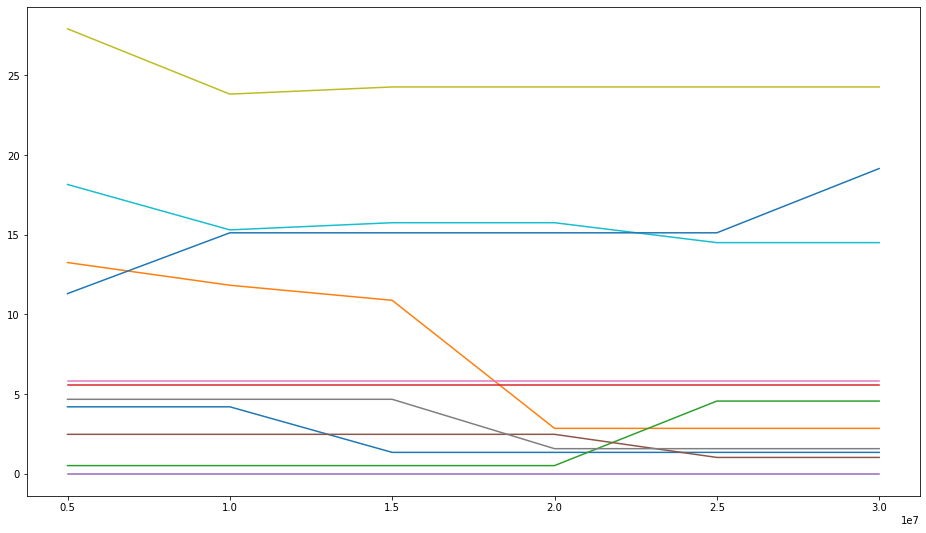

In [61]:
plt.figure(figsize=(16, 9))
plt_df = df.query('~modal_nash_conv.isnull() and run.str.contains("jun19_1_")').groupby('run').filter(lambda grp: len(grp) > 1).sort_values('t')
for r, sub_df in plt_df.groupby('run'):
    # display(sub_df)
    plt.plot(sub_df['t'].values, sub_df['modal_nash_conv'].values)
# plt.legend()
# plt.semilogy()
# sns.lineplot(data=plt_df, y='modal_nash_conv', x='t', hue='run', legend=False)


In [ ]:
len(e.get_model()._infostates)

In [ ]:
dir(e)

# Analyze runs

In [ ]:
# empirical = True
USE_MODAL = True

records = []
for run in tqdm(runs):
    try:
    
        try:
            game, final_checkpoint, policy = get_results(run, skip_single_chance_nodes=False)
        except Exception as e:
            print(f"Skipping run {run.name} because of error {e}")
            continue

        if USE_MODAL:
            evaluation = final_checkpoint.get_modal_eval()
            # if make_combo_specific(evaluation):
            #     print(run.name)
        else:
            evaluation = final_checkpoint.get_old_eval()
            
            
        # total_entropy = analyze_samples(final_checkpoint.get_old_eval().samples, game)['total_entropy'] # Use old eval since modal is stupid for this and it's a convergence test

        # if empirical: 
        #     history_dists = empirical_history_distribution(final_checkpoint.get_old_eval()) # Always use the old eval here
        #     history_entropies = [scipy.stats.entropy(list(history_dists.loc[type_combo].values)) for type_combo in np.unique(history_dists.index.get_level_values(0))]
        # else:
        #     history_dists = compute_per_type_combo(history_distribution, policy, game, min_prob=0.01, history_type='processed')
        #     history_entropies = [scipy.stats.entropy(list(history_dists[type_combo].values())) for type_combo in history_dists]

        # try:
        #     # TODO: Broken until you remove "Tremble" agents
        #     _, _, approx_nash_conv = find_best_checkpoint(run)
        # except:
        #     # TODO: Fix bug where this actually happens because your BRs failed to do better and you have an Empirical Nash Conv of 0, very different from NaN
        #     # ev_df = parse_run(run, None)
        #     # display(ev_df)
        #     approx_nash_conv = np.nan

        record = {
            # clock auction params
            'game_name': run.game.name, 
            'potential': run.config.get('potential_function', 'None'),
            'seed': run.config.get('seed'), 
            'run_name': run.name,
            'experiment': run.experiment.name,
            'config': run.get_config_name(),
            't': final_checkpoint.t,

            # CMA knobs
            'information_policy': InformationPolicy(game.auction_params.information_policy).name,
            'clock_speed': game.auction_params.increment,
            'base_game_name': '_'.join(run.game.name.split('/')[1].split('_')[:2]), # Stupid naming convention that will surely bite us later

            # solver information
            'alg': get_algorithm_from_run(run),
            'walltime': run.walltime(),

            # 'approx_nash_conv': approx_nash_conv,

            # metrics from eval
            # **analyze_samples(evaluation.samples, game),
            # 'total_entropy': total_entropy,

            # stats about history distribution
            # 'avg_distinct_histories': np.mean([len(d) for d in history_dists.values()]),
            # 'avg_history_entropy': np.mean(history_entropies),
        } 
        
        record['nash_conv'] = final_checkpoint.get_modal_eval().nash_conv

        # Slowwwwww you may want to comment this out when not using it
#         start = time.time()
#         c = final_checkpoint.equilibrium_solver_run.config
#         cfr = c.get('solver_type') == 'cfr'
#         env_and_policy = ppo_db_checkpoint_loader(final_checkpoint, cfr=cfr)
#         for player in range(game.num_players()):
#             env_and_policy.agents[player] = ModalAgentDecorator(env_and_policy.agents[player])
#         modal_policy = env_and_policy.make_policy()
        
#         worked, nc = time_bounded_run(30, nash_conv, game, modal_policy)
#         if not worked:
#             print("Aborted run because time")
#         record['nash_conv'] = nc if worked else np.nan
#         record['nash_conv_time'] = time.time() - start
#         print(time.time() - start)



        records.append(record)
    except Exception as e:
        print(f"Something wrong with {run}. Skipping {e}")
print(len(records))

In [ ]:
df = pd.DataFrame.from_records(records)
# df['imperfect'] = df['game_name'].str.contains('imperfect')


In [ ]:
df

In [ ]:
df.groupby('config')['walltime'].describe() / 3600

In [ ]:
df.query('~imperfect')['config'].value_counts(dropna=False)

In [ ]:
df.query('~imperfect').groupby('config')['nash_conv'].describe()

In [ ]:
df.query('~nash_conv.isnull()').sample(10)

In [ ]:
df = _

In [ ]:
df['run_name'].values

In [ ]:
df.groupby('experiment')['avg_history_entropy'].describe()

In [ ]:
groupers = ['base_game_name', 'clock_speed', 'information_policy']
df.sort_values(groupers).set_index([df.index]+groupers, drop=True).to_csv('jun5_results.csv')

In [ ]:
df.sort_values(groupers).set_index([df.index]+groupers, drop=True)
df.to_csv('greg3.csv')

In [ ]:
palette = {
    "('SHOW_DEMAND', 0.3)": 'blue',
    "('SHOW_DEMAND', 0.45)": 'orange',
    "('SHOW_DEMAND', 0.6)": 'green'
}

In [ ]:
df.columns

In [ ]:
ATTRIBUTE = 'variant'
NORMALIZED = False
plot_type = 'scatter'
box_df = df.copy()
markers = ['o', 'X', '^']

box_df['variant'] = list(map(str,(zip(box_df.information_policy, box_df.clock_speed))))

# box_df = box_df.query('clock_speed == 0.3')
box_df = box_df.query('information_policy == "SHOW_DEMAND"')
box_df = box_df.sort_values(['clock_speed', 'game_name', 'config'])

STATS = ['total_revenue', 'total_welfare', 'auction_lengths', 'total_entropy']
# Normalize by the mean of the "base" version, so the scales line up better in the same graph
if NORMALIZED: 
    for stat in STATS:
        base = str(('SHOW_DEMAND', 0.3))
        base_stat = box_df.pivot_table(index=['base_game_name'], values=stat, aggfunc='mean', columns=ATTRIBUTE)
        box_df[f'normalized_{stat}'] = box_df.apply(lambda x: x[stat] / base_stat.loc[x['base_game_name'], base], axis=1)

for stat in STATS:
    if NORMALIZED:
        stat = f'normalized_{stat}'
    plt.figure(figsize=(20,10))
    if plot_type == 'box':
        ax = sns.boxplot(data=box_df, x='base_game_name', y=stat, hue=ATTRIBUTE)
        # ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    else:
        strip_kwargs = dict(x='base_game_name', y=stat, hue=ATTRIBUTE, s=10, alpha=0.5, dodge=True, jitter=False, palette=palette)
        for i, config in enumerate(box_df['config'].unique()):
            # print(config, markers[i])
            ax = sns.stripplot(data=box_df.query(f'config == "{config}"'), marker=markers[i], **strip_kwargs)
            if i == 0:
                old_handles, old_labels = ax.get_legend_handles_labels()
            # ax = sns.stripplot(data=box_df.query('alg.str.contains("PPO") and imperfect'), marker='X', **strip_kwargs)
            # ax = sns.stripplot(data=box_df.query('alg.str.contains("cfr")'), marker='^', **strip_kwargs)
        ax.legend(old_handles, old_labels)

    plt.title(f"{stat}")

In [ ]:


# ### Code to rerun evals for a failed experiment
# from open_spiel.python.examples.ubc_dispatch import dispatch_eval_database
# exp = 'jun5outcome'

# for e in Evaluation.objects.filter(checkpoint__equilibrium_solver_run__experiment__name=exp):
#     experiment_name = e.checkpoint.equilibrium_solver_run.experiment.name
#     run_name = e.checkpoint.equilibrium_solver_run.name
#     t = e.checkpoint.t
#     dispatch_eval_database(experiment_name, run_name, t, None, None)
# print(Evaluation.objects.filter(checkpoint__equilibrium_solver_run__experiment__name=exp).delete())

In [ ]:
df.query('alg == "PPO"').groupby(['experiment', 'imperfect']).mean()

In [ ]:
records = []

for run in tqdm(runs):
    try:
        ev_df = parse_run(run, expected_additional_br=0)
        if ev_df is None:
            continue
        ev_df = ev_df.query('name == "modal"')
        if not ev_df.empty:
            val = ((ev_df['Regret'] / ev_df['Baseline']).mean() * 100)
            record = dict(val=val, alg=get_algorithm_from_run(run), game=run.game.name)
            records.append(record)
    except KeyError as e:
        continue
val_df = pd.DataFrame.from_records(records)

In [ ]:
# val_df.groupby(['game', 'alg']).describe()
val_df.groupby(['game', 'alg']).describe()

In [ ]:
# import open_spiel.python.examples.ubc_dispatch as dispatch
# for run in runs:
#     try:
#         game, final_checkpoint, policy = get_results(run, skip_single_chance_nodes=False)
#     except:
#         print("Skipping", run)
#         continue
#     final_checkpoint.bestresponse_set.all().delete()
#     for player in range(game.num_players()):
#         dispatch.dispatch_eval_database(run.experiment.name, run.name, final_checkpoint.t, player, 'modal') 
#         dispatch.dispatch_eval_database(run.experiment.name, run.name, final_checkpoint.t, player, 'tremble')  

In [ ]:
x = {'blue': 3, 'red': 1111, "string": 'tortoise'}
y = str(x)
y

In [ ]:
eval(y)

In [ ]:
for run in runs:
    try:
        game, final_checkpoint, policy = get_results(run, skip_single_chance_nodes=False)
    except Exception as e:
        print(f"Skipping run {run.name} because of error {e}")
        continue

    ev = final_checkpoint.get_modal_eval()
    if ev.nash_conv:
        continue
    else:
        ev.delete()
        br_mapping = {p: 'modal' for p in range(2)}
        dispatch.dispatch_eval_database(final_checkpoint.t, run.experiment.name, run.name, str(br_mapping))

In [ ]:
game = pyspiel.load_game('python_clock_auction')

In [ ]:
a = game.new_initial_state()

In [ ]:
b = a.child(0).child(0)

In [ ]:
a.auction_params

In [ ]:
id(a.auction_params.player_types[0][0]['bidder'])

In [ ]:
id(b.auction_params.player_types[0][0]['bidder'])

In [ ]:
id(a.auction_params), id(b.auction_params)

In [ ]:
x = a.auction_params
id(x)

In [ ]:
id(a.get_game()) == id(b.get_game())